In [1]:
# Makes the display take up more of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [43]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
import time

In [4]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
def set_seed(x): 
    #random.seed(x)
    np.random.seed(x)
    T.manual_seed(x)
    T.backends.cudnn.deterministic = True
    T.backends.cudnn.benchmark = False
    if T.cuda.is_available(): 
        T.cuda.manual_seed_all(x)

In [6]:
seed= 42
set_seed(seed)

# Broadcasting

In [7]:
class PolicyNetwork(nn.Module):
    def __init__(self, lr, input_dims, n_actions):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(*input_dims,128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128, n_actions)
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state):
        x1 = F.relu(self.fc1(state))
        x2 = F.relu(self.fc2(x1))
        x3 = self.fc3(x2)
        
        return x3   

In [8]:
class PolicyGradientAgent():
    def __init__(self, lr, input_dims, gamma= 0.99, n_actions=4):
        self.gamma = gamma
        self.lr = lr
        self.reward_memory = []
        self.action_memory = []
        
        self.reward_memory_saved = []
        self.action_memory_saved = []
        
        self.policy = PolicyNetwork(self.lr, input_dims, n_actions)
        
    def choose_action(self, observation):
        state = T.Tensor([observation]).to(self.policy.device)
        probabilities = F.softmax(self.policy.forward(state))
        action_probs = T.distributions.Categorical(probabilities)
        action = action_probs.sample()
        log_probs = action_probs.log_prob(action)
        self.action_memory.append(log_probs)
        
        return action.item()
    
    def store_rewards(self, reward):
        self.reward_memory.append(reward)
               
    def learn(self):
        self.policy.optimizer.zero_grad()
        
        # G_t = R_t+1 + gamma * R_t+2 + gamma**2 * R_t+3
        # G_t = sum from k=0 to k=T {gamma**k * R_t+k+1}
        
        # too many for loops
        #G = np.zeros_like(self.reward_memory, dtype=np.float64)
        #for t in range(len(self.reward_memory)):
        #    G_sum=0
        #    discount=1
        #    for k in range(t, len(self.action_memory)):
        #        G_sum += self.reward_memory[k] *discount
        #        discount *= self.gamma
        #    G[t]=G_sum
        
        #Removed for loops by broadcasting
        arr_rwrd=np.triu([self.reward_memory]*len(self.action_memory), k=0)
        n = len(self.action_memory)
        b = np.zeros(2 * n+1)
        b[n:] = self.gamma ** np.arange(n+1)
        s, = b.strides
        dscnt = np.lib.stride_tricks.as_strided(b[n:], shape=(n, n), strides=(-s, s), writeable=False)
        G=(arr_rwrd*dscnt).sum(axis=1)
        
        G = T.tensor(G, dtype=T.float).to(self.policy.device)
        
        loss=0
        for g, logprob in zip(G, self.action_memory):
            loss+= -g * logprob
        loss.backward()
        self.policy.optimizer.step()
        
        self.reward_memory_saved.append(self.reward_memory)
        self.action_memory_saved.append(self.action_memory)
        
        self.reward_memory = []
        self.action_memory = []

In [9]:
env = gym.make('LunarLander-v2')
env.seed(seed)
n_games = 3001
agent = PolicyGradientAgent(gamma=0.99, lr=0.0005, input_dims=[8],
                            n_actions=4)
episode_time=[]
scores = []
for i in range(n_games):
    toc= time.time()
    done = False
    observation = env.reset()
    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.store_rewards(reward)
        observation = observation_
    agent.learn()
    scores.append(score)
    tic=time.time()
    episode_time.append(tic-toc)
    intvl=250
    if i % intvl == 0:
        avg_score = np.mean(scores[-intvl:])
        avg_time = np.mean(episode_time[-intvl:])
        print('Episode ', i, 'Score %.2f' % score, 'Average score %.2f' % avg_score, 'Average episode time %.2f' % avg_time, '(sec)')
env.close()

C:\Users\M323742\Anaconda3\envs\DeepRL\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Episode  0 Score -254.51 Average score -254.51 Average episode time 0.19 (sec)
Episode  250 Score -24.39 Average score -156.90 Average episode time 0.09 (sec)
Episode  500 Score -117.73 Average score -137.29 Average episode time 0.12 (sec)
Episode  750 Score -98.48 Average score -115.07 Average episode time 0.11 (sec)
Episode  1000 Score -96.45 Average score -75.60 Average episode time 0.16 (sec)
Episode  1250 Score 23.85 Average score -26.97 Average episode time 0.26 (sec)
Episode  1500 Score 126.07 Average score 17.17 Average episode time 0.99 (sec)
Episode  1750 Score -34.05 Average score 53.25 Average episode time 1.11 (sec)
Episode  2000 Score 140.32 Average score 99.59 Average episode time 1.76 (sec)
Episode  2250 Score -219.67 Average score 60.28 Average episode time 0.96 (sec)
Episode  2500 Score 165.42 Average score 92.77 Average episode time 0.73 (sec)
Episode  2750 Score -71.41 Average score 65.49 Average episode time 0.99 (sec)
Episode  3000 Score 42.46 Average score 103.42

In [10]:
print('Time to complete %.2f', np.array(episode_time).sum()/60, '(minutes)')

Time to complete %.2f 34.06503071784973 (minutes)


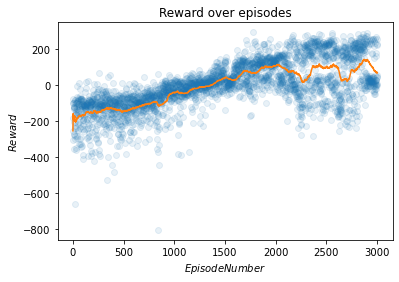

In [11]:
x = [i+1 for i in range(len(scores))]
running_avg = np.zeros(len(scores))
for i in range(len(running_avg)):
    running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])

plt.plot(x, scores, 'o', alpha=0.1)
plt.plot(x, running_avg)
plt.title('Reward over episodes')
plt.ylabel(r'$Reward$')
plt.xlabel(r'$Episode Number$')
plt.show()

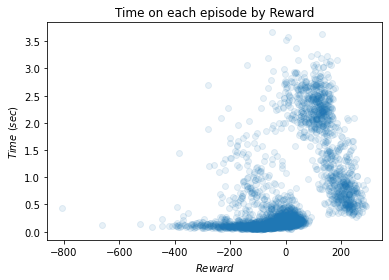

In [12]:
x = scores
y=episode_time
plt.plot(x, y, 'o', alpha=0.1)

plt.title('Time on each episode by Reward')
plt.ylabel(r'$Time \ (sec)$')
plt.xlabel(r'$Reward$')
plt.show()

##### test to see how much fast the vectorized calucation is

In [33]:
self=agent
self.reward_memory = self.reward_memory_saved[-1]
self.action_memory = self.action_memory_saved[-1]

In [34]:
len( self.reward_memory_saved), len(self.reward_memory),len(self.action_memory)

(3001, 1000, 1000)

In [37]:
%timeit np.triu([self.reward_memory]*len(self.action_memory), k=0)

10 loops, best of 3: 71.2 ms per loop


In [44]:
pd.DataFrame(np.triu([self.reward_memory]*len(self.action_memory), k=0))

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.302758,-0.071668,1.540201,-0.14559,1.568262,1.625002,1.840486,1.991143,1.762171,1.65241,...,-0.394255,0.153895,0.082987,0.022155,-0.502247,0.316291,-0.090363,0.122485,-0.064629,-0.254646
1,0.000000,-0.071668,1.540201,-0.14559,1.568262,1.625002,1.840486,1.991143,1.762171,1.65241,...,-0.394255,0.153895,0.082987,0.022155,-0.502247,0.316291,-0.090363,0.122485,-0.064629,-0.254646
2,0.000000,0.000000,1.540201,-0.14559,1.568262,1.625002,1.840486,1.991143,1.762171,1.65241,...,-0.394255,0.153895,0.082987,0.022155,-0.502247,0.316291,-0.090363,0.122485,-0.064629,-0.254646
3,0.000000,0.000000,0.000000,-0.14559,1.568262,1.625002,1.840486,1.991143,1.762171,1.65241,...,-0.394255,0.153895,0.082987,0.022155,-0.502247,0.316291,-0.090363,0.122485,-0.064629,-0.254646
4,0.000000,0.000000,0.000000,0.00000,1.568262,1.625002,1.840486,1.991143,1.762171,1.65241,...,-0.394255,0.153895,0.082987,0.022155,-0.502247,0.316291,-0.090363,0.122485,-0.064629,-0.254646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.316291,-0.090363,0.122485,-0.064629,-0.254646
996,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.090363,0.122485,-0.064629,-0.254646
997,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.122485,-0.064629,-0.254646
998,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.064629,-0.254646


In [35]:
%%timeit
arr_rwrd=np.triu([self.reward_memory]*len(self.action_memory), k=0)
n = len(self.action_memory)
b = np.zeros(2 * n+1)
b[n:] = self.gamma ** np.arange(n+1)
s, = b.strides
dscnt = np.lib.stride_tricks.as_strided(b[n:], shape=(n, n), strides=(-s, s), writeable=False)
G = (arr_rwrd*dscnt).sum(axis=1)

10 loops, best of 3: 78.9 ms per loop


In [ ]:
# https://stackoverflow.com/questions/62820339/numpy-create-upper-triangular-matrix-with-diagonals-of-increasing-power/62820764#62820764

In [36]:
%%timeit
G = np.zeros_like(self.reward_memory, dtype=np.float64)
for t in range(len(self.reward_memory)):
    G_sum=0
    discount=1
    for k in range(t, len(self.action_memory)):
        G_sum += self.reward_memory[k] *discount
        discount *= self.gamma
    G[t]=G_sum

10 loops, best of 3: 160 ms per loop


## Result:
* Vecortized code is twices as fast for calculating G

# Fin

In [13]:
end=dt.datetime.now()
print(f'Finished: {end.strftime("%A %B %d, %Y")} at {end.strftime("%H:%M")}')

Finished: Tuesday September 28, 2021 at 10:15
